In [1]:
from sklearn.utils import class_weight
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

import pandas as pd
from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import re
from gensim.parsing.preprocessing import remove_stopwords

import tensorflow as tf
import tensorflow_hub
import tensorflow_text

import nltk
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

import openpyxl
import warnings
import random
import os

import pickle

import matplotlib.font_manager
warnings.filterwarnings('ignore')  # Filter Errors
plt.rcParams['font.family'] = 'Times New Roman'  # Set plt shows font to Times New Roman
plt.rcParams['axes.grid'] = True  # Ensure line graphs display on graphs

In [2]:
def text_cleaner(text):
    """
    Removes stopwords, words shorter than 3 characters, all links (href), emojis, & punctuation.
    :type text: string
    """
    additional_stopwords = set(['br', 'the', 'i', 'me', 'my', 'myself', 
                                'we', 'our', 'ours', 'ourselves', 'you', 
                                "you're", "you've", "you'll", "you'd", 'your', 
                                'yours', 'yourself', 'yourselves', 'he', 'him', 
                                'his', 'himself', 'she', "she's", 'her', 'hers',
                                'herself', 'it', "it's", 'its', 'itself', 'they',
                                'them', 'their', 'theirs', 'themselves', 'what',
                                'which', 'who', 'whom', 'this', 'that', "that'll",
                                'these', 'those', 'am', 'is', 'are', 'was', 'were',
                                'be', 'been', 'being', 'have', 'has', 'had', 'having',
                                'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and',
                                'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of',
                                'at', 'by', 'for', 'with', 'about', 'against', 'between',
                                'into', 'through', 'during', 'before', 'after', 'above', 
                                'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off',
                                'over', 'under', 'again', 'further', 'then', 'once', 'here',
                                'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both',
                                'each', 'few', 'more', 'most', 'other', 'some', 'such', 'only',
                                'own', 'same', 'so', 'than', 'too', 'very', 's', 't', 'can',
                                'will', 'just', 'don', "don't", 'should', "should've", 'now',
                                'd', 'll', 'm', 'o', 're', 've', 'y', 'ain', 'aren', "aren't", 
                                'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn', 
                                "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma',
                                'mightn', "mightn't", 'mustn', "mustn't", 'needn', "needn't", 'shan', 
                                "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't",
                                'won', "won't", 'wouldn', "wouldn't"])
    emoji_pattern = re.compile("["
                               u"\U0001F600-\U0001F64F"  # emoticons
                               u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                               u"\U0001F680-\U0001F6FF"  # transport & map symbols
                               u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                               "]+", flags=re.UNICODE)
    
    text = text[2:-1]  # Remove the leading b, it looks like it's encoded but it's not
    text = text.replace('&amp;', 'and')
    text = text.replace(r"\'s", r"'s'")
    text = re.sub(r'[0-9]', ' ', text) # Match all digits in the string and replace them by empty string
    text = ' '.join(filter(lambda x:x[0]!=r'//', text.split()))
    text = ' '.join(re.sub(r'(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)',' ', text).split())  # Remove hashtags #Derek, would be '' & https: links
    
    text = re.sub(emoji_pattern, '', text)  # Remove all emoji patterns
    text = re.sub("<a.+?>", ' ', text)  # Remove url, but keep the label
    
    html_tag_cleaner = re.compile('<.*?>')  # Remove any html div
    text = re.sub(html_tag_cleaner, '', text)  # Execute html removal
    
    text = re.sub(r'[^A-Za-z0-9 ]+', ' ', text)  # Remove all special characters
    text = re.sub(r'\b\w{1,3}\b', ' ', text)  # Remove all words less than or equal to 3 characters
    text = text.lower()  # Lower case text
    text = remove_stopwords(text)  # Removes stop words
    # Remove contractions or other custom stopwords
    text = ' '.join(e.lower() for e in text.split() if e.lower() not in additional_stopwords)
    
    text = re.sub(r"won't", "will not", text)  # Replace these words
    text = re.sub(r"can\'t", "can not", text)  # Replace these words
    text = re.sub(r"n\'t", " not", text)  # Replace these words
    text = re.sub(r"\'re", " are", text)  # Replace these words
    text = re.sub(r"\'s", " is", text)  # Replace these words
    text = re.sub(r"\'d", " would", text)  # Replace these words
    text = re.sub(r"\'ll", " will", text)  # Replace these words
    text = re.sub(r"\'t", " not", text)  # Replace these words
    text = re.sub(r"\'ve", " have", text)  # Replace these words
    text = re.sub(r"\'m", " am", text)  # Replace these words
    
    text = re.sub(' +', ' ', text)  # Remove double whitespace
    text = text.strip()  # Remove leading & trailing whitespace
    return text

In [3]:
# Tags the words in the text
def nltk_tag_to_wordnet_tag(nltk_tag):
    if nltk_tag.startswith('J'):
        return(nltk.corpus.wordnet.ADJ)
    elif nltk_tag.startswith('V'):
        return(nltk.corpus.wordnet.VERB)
    elif nltk_tag.startswith('N'):
        return(nltk.corpus.wordnet.NOUN)
    elif nltk_tag.startswith('R'):
        return(nltk.corpus.wordnet.ADV)
    else:
        return(None)

In [4]:
lemmatizer = WordNetLemmatizer()


# Lemmatizes the words in texts and returns the cleaned and lemmatized text
def lemmatize_text(text):
    # Tokenize the text and find the POS tag for each token
    text = text_cleaner(text)
    nltk_tagged = nltk.pos_tag(nltk.word_tokenize(text))  
    # Tuple of (token, wordnet_tag)
    wordnet_tagged = map(lambda x: (x[0], nltk_tag_to_wordnet_tag(x[1])), nltk_tagged)
    lemmatized_text = []
    for word, tag in wordnet_tagged:
        if tag is None: # If there is no available tag, append the token as is
            lemmatized_text.append(word)
        else:  # Else use the tag to lemmatize the token
            lemmatized_text.append(lemmatizer.lemmatize(word, tag))
    return(' '.join(lemmatized_text))

## Model Creation
<a class='anchor' id='model-creation'></a>

In [5]:
# Import the raw dataset
training_tweet_df = pd.read_csv(r'congressional_tweet_training_data.csv')
test_tweet_df = pd.read_csv(r'congressional_tweet_test_data.csv')

In [6]:
int_to_party_dict = {
    0: 'D',
    1: 'R'
}

party_to_int_dict = {
    'D': 0,
    'R': 1
}

In [7]:
X_train = training_tweet_df['full_text']
y_train = training_tweet_df['party_id'].map(party_to_int_dict)
y_train = y_train.values

X_test = test_tweet_df['full_text']
y_test = test_tweet_df['party'].map(party_to_int_dict)
y_test = y_test.values

In [9]:
X_train['full_text_clean'] = X_train.apply(lambda x: lemmatize_text(x))

In [10]:
bert_preprocess = tensorflow_hub.KerasLayer(r'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3')
bert_encoder = tensorflow_hub.KerasLayer(r'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4')

In [11]:
text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')

preprocessed_text = bert_preprocess(text_input)
outputs = bert_encoder(preprocessed_text)

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


In [13]:
l = tf.keras.layers.Dropout(0.1, name='dropout')(outputs['pooled_output'])
l = tf.keras.layers.Dense(1, activation='relu', name='output')(l)

model = tf.keras.Model(inputs=[text_input], outputs = [l])

metrics = [
    tf.keras.metrics.BinaryAccuracy(name='accuracy'),
    tf.keras.metrics.Precision(name='precision'),
    tf.keras.metrics.Recall(name='recall')
]

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=metrics)

In [14]:
model.fit(X_train['full_text_clean'].to_numpy(), y_train, epochs=5)

Epoch 1/5
  264/18526 [..............................] - ETA: 14:00:48 - loss: 6.9906 - accuracy: 0.5468 - precision: 0.0025 - recall: 1.9672e-06    

InvalidArgumentError:  assertion failed: [predictions must be <= 1] [Condition x <= y did not hold element-wise:] [x (model_1/output/Relu:0) = ] [[0.449964762][0][0.722315371]...] [y (Cast_9/x:0) = ] [1]
	 [[{{node assert_less_equal/Assert/AssertGuard/else/_2217/assert_less_equal/Assert/AssertGuard/Assert}}]] [Op:__inference_train_function_70846]

Function call stack:
train_function


In [ ]:
def predict_tweet_party(test_x_dataframe, trained_model):
    """
    Pipeline for preprocessing and prediciton.
    """
#     Clean the Summary Text column
    test_x_dataframe['full_text_clean'] = test_x_dataframe.apply(lambda x: lemmatize_text(x))
    predictions = trained_model.predict(test_x_dataframe['full_text_clean'].to_numpy())  # Predict
    predictions = predictions.flatten()
    return predictions

In [ ]:
predictions = predict_tweet_party(X_test, model)

## Prediction
<a class='anchor' id='prediction'></a>

In [ ]:
submission = test_tweet_df.copy()
submission['party'] = predictions
submission['party'] = submission['party'].map(int_to_party_dict)

In [ ]:
submission[['Id', 'party']].to_csv('output.csv', index=False)  # Export these features without the index

## Evaulation
<a class='anchor' id='evaulation'></a>

              precision    recall  f1-score   support

           0       1.00      0.55      0.71    265000
           1       0.00      0.00      0.00         0

   micro avg       0.55      0.55      0.55    265000
   macro avg       0.50      0.27      0.35    265000
weighted avg       1.00      0.55      0.71    265000



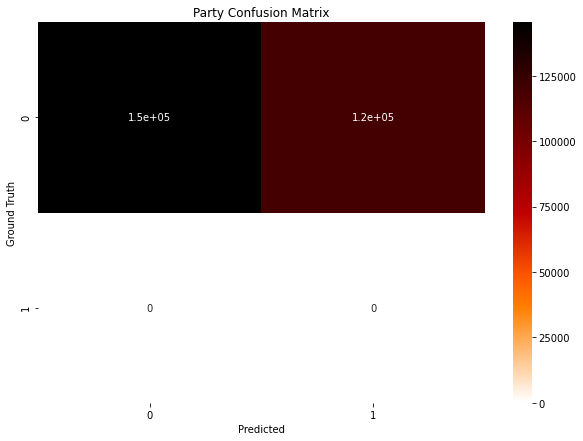

In [41]:
conf_matrix = confusion_matrix(y_true=y_test, y_pred=predictions)  # Calculate the confusion matrix

plt.figure(figsize = (10,7))  # Initialize plot figure
ax = sns.heatmap(conf_matrix, # Heat map the confusion matrix
                 annot=True,   # Plot the counts on each block
                 cmap='gist_heat_r',  # Reverse the heat map so it is more bright
                )

ax.set(xlabel='Predicted', ylabel='Ground Truth', title='Party Confusion Matrix')
print(classification_report(y_true=y_test, y_pred=predictions))  # Print the classification report
plt.show()  # Show the image